In [ ]:
%load_ext autoreload
%autoreload 2
from lens_simulation.Lens import Lens, LensType, GratingSettings
from lens_simulation.Medium import Medium, LithiumNiabate

from lens_simulation.structures import SimulationOptions, SimulationParameters
from lens_simulation import utils
import matplotlib.pyplot as plt

import numpy as np


In [ ]:
# create lens
parameters = SimulationParameters(
    A=10000,
    pixel_size=1e-6,
    sim_height=1000e-6,
    sim_width=1000e-6,
    sim_wavelength=488e-9,
    lens_type=LensType.Spherical,
)



In [ ]:

from lens_simulation.Lens import test_escape_path_fits_inside_simulation
from lens_simulation.Simulation import pad_simulation

ep = 0.5
lens_type = LensType.Cylindrical
lens_type = LensType.Spherical

lens = Lens(500e-6, 50e-6, 2.0, LithiumNiabate())
lens.generate_profile(parameters.pixel_size, lens_type, length=200e-6)

print("lens: ", lens.profile.shape)
plt.imshow(lens.profile, cmap="plasma")
plt.title("lens profile")
plt.show()

# aperture
lens.create_custom_aperture(100e-6, 150e-6, type="radial", inverted=False)

# truncation
lens.create_truncation_mask(truncation_height=49e-6, aperture=True)

grating_settings = GratingSettings(
    width = 25e-6,
    distance = 50e-6,
    depth = 20e-6,
    centred = True
)

lens.create_grating_mask(grating_settings, True, True)

lens.apply_masks(grating=True, truncation=True)

# escape path
lens.create_escape_path(parameters, ep)

# pad simulation
lens = pad_simulation(lens, parameters)

# apply all mask
lens.apply_aperture_masks()

fig = utils.plot_apeture_masks(lens)
plt.show()

fig = utils.plot_lens_modifications(lens)
plt.show()



# TODO: add escape path to config


In [ ]:
test_escape_path_fits_inside_simulation(lens, parameters, ep=0.1)
test_escape_path_fits_inside_simulation(lens, parameters, ep=0.5)
test_escape_path_fits_inside_simulation(lens, parameters, ep=1.5)

In [ ]:
from lens_simulation import utils, validation
from lens_simulation.Lens import Lens, generate_lens, LensType
from lens_simulation.Medium import LithiumNiabate
from pprint import pprint

lens_config = utils.load_yaml_config("lens.yaml")

print("before validation")
pprint(lens_config)

lens_config = validation._validate_default_lens_config(lens_config)

print("after validation")
pprint(lens_config)

lens = generate_lens(lens_config, LithiumNiabate())

lens.generate_profile(1e-6)

# external pixel_size, lens_type

import matplotlib.pyplot as plt
plt.imshow(lens.profile)
plt.show()



#### Plot Slices as GIF
Plot the simulation slices as gif



In [ ]:
%load_ext autoreload
%autoreload 2
import os
from lens_simulation import utils
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt


print(os.getcwd())

path = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\rarely-upward-ocelot\safe-hound"

sim_path = os.path.join(path, str(0))
utils.save_propagation_gif(sim_path)

sim_path = os.path.join(path, str(1))
utils.save_propagation_gif(sim_path)


In [ ]:

# stack slices
sim_path = os.path.join(path, str(1))

utils.save_propagation_slices_gif(sim_path)

In [ ]:

print(sim_path)

filenames = sorted(glob.glob(os.path.join(sim_path, "*mm.npy")))

# TODO: might not be possible for very large sims to load full sim, 
# will need to come up with another way to load slices in right format

# sim = None
# print(f"{len(filenames)} slices.")

# vslice = None
# hslice = None


# for i each dim in slice (301)
    # for each j slice (58)
        # get slice column
        # set to vslice arr column
        # vslice[j, i] = slice[i,]

# slice = np.load(filenames[0])
# vslice = np.zeros(shape=(len(filenames), slice.shape[0]))


# for i in range(slice.shape[0]):
#     for j, fname in enumerate(filenames):

#         slice = np.load(fname)
        
#         vslice[j, i] = slice[i, :] 

#         print(f"{i}, {j}")
#         print(f"fname: {os.path.basename(fname)}")
#         print(f"shape: {slice.shape}")
#         print(f"vslice: {vslice.shape})")
#         # print(f"hslice: {hslice.shape})")
    




### Simulation Data Aggregation


In [ ]:
import os
import glob


directory = r"//ad.monash.edu/home/User028/pcle0002/Documents/repos/lens_simulation/src/lens_simulation/log/rarely-upward-ocelot"

sim_run_name = os.path.basename(directory)

sim_directories = [path for path in os.listdir(directory) if os.path.isdir(os.path.join(directory, path))] 

print("directory: ", directory)
print("sim_run_name: ", sim_run_name)
print("sim_dir: ", sim_directories)






In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from lens_simulation import utils
path = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\duly-fancy-panda\sweet-mako"

pd.set_option("display.max_rows", None, "display.max_columns", None)

# df_join = load_simulation_data(path)

print(f"path: {path}")
from pprint import pprint

# print("stages: ")
# display(df_stages)

# print("lens: ")
# display(df_lens)


# print("beam: ")
# display(df_beam)


print("join")
# display(df_join)



In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from lens_simulation import utils
# path = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\duly-fancy-panda\sweet-mako"
pd.set_option("display.max_rows", None, "display.max_columns", None)

directory = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\barely-ideal-zebra"
directory = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\lively-vital-duck"


df = utils.load_run_simulation_data(directory)

print(f"run: {os.path.basename(directory)}")
display(df.T)


df.to_csv("data.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
run: lively-vital-duck


,0,1,2,3,4,5
lens,lens_1,lens_2,lens_1,lens_2,lens_1,lens_2
output,1.33,1.0,1.33,1.0,1.33,1.0
start_distance,0.0,0.0,0.0,0.0,0.0,0.0
finish_distance,0.002953,0.001677,0.002953,0.001677,0.002953,0.001677
n_slices,NaN,10.0,NaN,10.0,NaN,10.0
step_size,0.0001,NaN,0.0001,NaN,0.0001,NaN
lens_inverted,False,False,False,False,False,False
stage,1,2,1,2,1,2
medium,2.348,2.348,2.348,2.348,2.348,2.348
diameter,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003


In [ ]:
display(df[df["exponent"] ==  2.1].T)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
lens_1
{'aperture': {'inner': 5e-05,
              'invert': False,
              'outer': 0.0001,
              'type': 'radial'},
 'diameter': 0.0003,
 'exponent': 2.0,
 'grating': {'centred': True,
             'depth': 1.5e-07,
             'distance': 2e-05,
             'width': 1e-05,
             'x': True,
             'y': False},
 'height': 1e-05,
 'inverted': False,
 'lens_type': 'Spherical',
 'medium': 2.348,
 'name': 'lens_1',
 'truncation': {'aperture': False,
                'height': 3e-06,
                'radius': 5e-05,
                'type': 'radial'}}


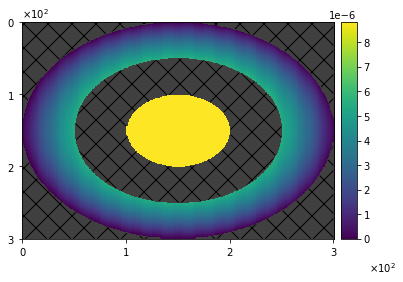

lens_2
{'diameter': 0.0003,
 'exponent': 2.4,
 'height': 1e-05,
 'lens_type': 'Spherical',
 'medium': 2.348,
 'name': 'lens_2'}


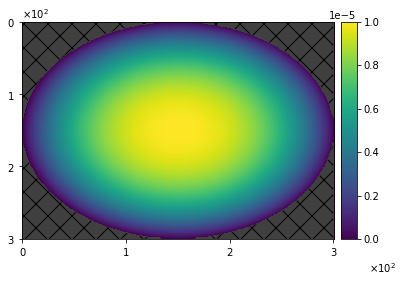

In [17]:
%load_ext autoreload
%autoreload 2

import lens_simulation
from lens_simulation import utils
from pprint import pprint
import matplotlib.pyplot as plt
from lens_simulation.Lens import generate_lens
from lens_simulation.Medium import Medium


config = utils.load_yaml_config("config.yaml")

# pprint(config)



for stage_config in config["stages"]:

    lens_name = stage_config["lens"]

    for conf in config["lenses"]:
        if conf["name"] == lens_name:
            lens_config = conf
    print(lens_name)
    pprint(lens_config)

    lens = generate_lens(lens_config, 
                Medium(lens_config["medium"], config["sim_parameters"]["sim_wavelength"]), 
                config["sim_parameters"]["pixel_size"])

    utils.plot_lens_profile_2D(lens)
    plt.show()


[{'finish_distance': 0.006,
  'lens': 'lens_1',
  'options': {'focal_distance_multiple': 2.0,
              'focal_distance_start_multiple': 0.0,
              'use_equivalent_focal_distance': True},
  'output': 1.33,
  'start_distance': 0,
  'step_size': 0.0001},
 {'finish_distance': 0.006,
  'lens': 'lens_2',
  'n_slices': 10,
  'options': {'focal_distance_multiple': 2.0,
              'focal_distance_start_multiple': 0.0,
              'use_equivalent_focal_distance': True},
  'output': 1.0,
  'start_distance': 0}]


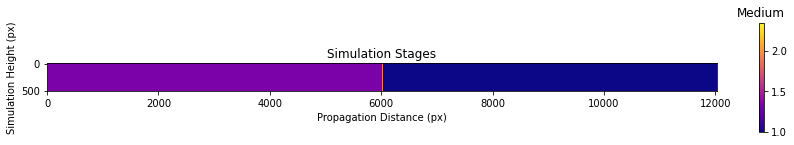

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from lens_simulation import utils
from pprint import pprint

config = utils.load_yaml_config("config.yaml")

pprint(config["stages"])



fig = utils.plot_simulation_setup(config)
plt.show()


{'A': 10000,
 'pixel_size': 1e-06,
 'sim_height': 0.0005,
 'sim_wavelength': 4.88e-07,
 'sim_width': 0.0005}
{'distance_mode': 'Direct',
 'final_width': None,
 'focal_multiple': None,
 'height': 0.0001,
 'lens_type': 'Spherical',
 'n_slices': 10,
 'numerical_aperture': None,
 'output_medium': 1.0,
 'position_x': 0.0001,
 'position_y': 0.0,
 'shape': 'Rectangular',
 'source_distance': 0.002,
 'spread': 'Plane',
 'step_size': 0,
 'theta': 0.0,
 'tilt_x': 0.0,
 'tilt_y': 0.0,
 'width': 0.0001}


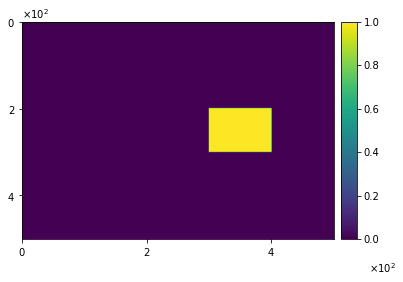

In [10]:

from lens_simulation.beam import  generate_beam
from lens_simulation.structures import SimulationParameters

config = utils.load_config("config.yaml")

def generate_parameters(config: dict) -> SimulationParameters:

    parameters = SimulationParameters(
        A = config["sim_parameters"]["A"],
        pixel_size=config["sim_parameters"]["pixel_size"],
        sim_width=config["sim_parameters"]["sim_width"],
        sim_height=config["sim_parameters"]["sim_height"],
        sim_wavelength=config["sim_parameters"]["sim_wavelength"]
        
    )

    return parameters

parameters = generate_parameters(config)
beam = generate_beam(config["beam"], parameters)

pprint(config["sim_parameters"])
pprint(config["beam"])

fig = utils.plot_lens_profile_2D(beam.lens)
plt.show()


In [7]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils
from pprint import pprint
from copy import deepcopy

# sweep
config = utils.load_config("config.yaml")

config["sweep"] = deepcopy(config)

pprint(config)


# config dict vs config yaml
# yaml creates the sweeps
# dicts create the objects




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'beam': {'distance_mode': 'Direct',
          'final_width': None,
          'focal_multiple': None,
          'height': 0.0005,
          'lens_type': 'Spherical',
          'n_slices': 10,
          'numerical_aperture': None,
          'output_medium': 1.0,
          'position_x': 0.0,
          'position_y': 0.0,
          'shape': 'Rectangular',
          'source_distance': 0.002,
          'spread': 'Plane',
          'step_size': 0,
          'theta': 0.0,
          'tilt_x': 0.0,
          'tilt_y': 0.0,
          'width': 0.0001},
 'lenses': [{'aperture': {'inner': 5e-05,
                          'invert': False,
                          'outer': 0.0001,
                          'type': 'radial'},
             'custom': None,
             'diameter': 0.0003,
             'escape_path': None,
             'exponent': 2.0,
             'grating': {'centred': True,
                        